# Helpers

In [1]:
import numpy as np
import os

from matplotlib import pyplot as plt 

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.utils_v2 import get_datasets_base_path

from steves_utils.transforms import get_chained_transform

In [2]:
import steves_utils.wisig.utils as wisig

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

In [3]:
SEED = 1337
N    = 5

In [4]:
"""
Get every example from the train dataset, coalesce them, and randomly pick N
This uses the same exact dataset pipeline as the experiments.

This is overkill, but I want to be thorough
"""
def get_examples(
    pickle_path:str,
    labels,
    domains,
    x_transforms=None,
)->tuple:
    if x_transforms == None:
        x_transform_func = None
    else:
        x_transform_func = get_chained_transform(x_transforms)
    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=-1,
        iterator_seed=SEED,
        dataset_seed=SEED,
        n_shot=3,
        n_way=16,
        n_query=3,
        train_val_test_k_factors=(1,1,1),
        pickle_path=pickle_path,
        x_transform_func=x_transform_func,
    )

    t = eaf.get_train()

    ex = []
    
    for u, (s_x, s_y, q_x, q_y, ground) in t:
        s_y_real = np.array(ground)[s_y]
        q_y_real = np.array(ground)[s_y]
        
        for x, y in zip(s_x, s_y):
            ex.append((x.numpy(),int(y.numpy()),u))
        for x, y in zip(q_x, q_y):
            ex.append((x.numpy(),int(y.numpy()),u))

    idxs = np.random.default_rng(SEED).choice(len(ex), size=N, replace=False)

    out = [ex[i] for i in idxs]
    
    return out

In [5]:
def do_time_plot(dataset, example, ax):
    ax.set_title(f"{dataset} y={example[1]} u={example[2]}")   
    x = example[0]    
    x = x[0] + 1.0j*x[1]

    ax.plot(range(len(x)),np.abs(x))
    
    plt.xlabel("t")
    plt.ylabel("magnitude")

def do_frequency_plot(dataset, example, ax):
    ax.set_title(f"{dataset} y={example[1]} u={example[2]}")   
    x = example[0]
    x = x[0] + 1.0j*x[1]
    f = 25e6
    signal_spectrum = np.fft.fftshift(np.fft.fft(x))
    freqs = np.fft.fftshift(np.fft.fftfreq(len(x), d=1.0/f))
    ax.plot(freqs / 1e6, np.abs(signal_spectrum))  # in MHz
    
    plt.xlabel("freq(MHz)")
    plt.ylabel("magnitude")

In [6]:
oracle_orig = get_examples(
    pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
    labels=ALL_SERIAL_NUMBERS,
    domains=ALL_DISTANCES_FEET_NARROWED,
)

cores_orig = get_examples(
    pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
    labels=ALL_NODES,
    domains=ALL_DAYS,
)

wisig_orig = get_examples(
    pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
    labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
    domains=wisig.ALL_DAYS,
)

In [7]:
oracle_resamp = get_examples(
    pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
    labels=ALL_SERIAL_NUMBERS,
    domains=ALL_DISTANCES_FEET_NARROWED,
    x_transforms = ["take_200", "resample_20Msps_to_25Msps"]
)

cores_resamp = get_examples(
    pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
    labels=ALL_NODES,
    domains=ALL_DAYS,
    x_transforms = ["take_200"]
)

wisig_resamp = get_examples(
    pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
    labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
    domains=wisig.ALL_DAYS,
    x_transforms = ["take_200"]
)

In [8]:
oracle_filter = oracle_resamp # oracle does not get resampled

cores_filter = get_examples(
    pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
    labels=ALL_NODES,
    domains=ALL_DAYS,
    x_transforms = ["lowpass_+/-10MHz", "take_200"]
)

wisig_filter = get_examples(
    pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
    labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
    domains=wisig.ALL_DAYS,
    x_transforms = ["lowpass_+/-10MHz", "take_200"]
)

In [9]:
oracle_unit_mag = get_examples(
    pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
    labels=ALL_SERIAL_NUMBERS,
    domains=ALL_DISTANCES_FEET_NARROWED,
    x_transforms = ["unit_mag"]
)

cores_unit_mag = get_examples(
    pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
    labels=ALL_NODES,
    domains=ALL_DAYS,
    x_transforms = ["unit_mag"]
)

wisig_unit_mag = get_examples(
    pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
    labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
    domains=wisig.ALL_DAYS,
    x_transforms = ["unit_mag"]
)

In [10]:
oracle_unit_power = get_examples(
    pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
    labels=ALL_SERIAL_NUMBERS,
    domains=ALL_DISTANCES_FEET_NARROWED,
    x_transforms = ["unit_power"]
)

cores_unit_power = get_examples(
    pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
    labels=ALL_NODES,
    domains=ALL_DAYS,
    x_transforms = ["unit_power"]
)

wisig_unit_power = get_examples(
    pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
    labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
    domains=wisig.ALL_DAYS,
    x_transforms = ["unit_power"]
)

# Baseline (Time Domain)
No processing applied.  
The cyclic nature of the short training sequence is apparent.  
We can also immediately tell that the cyclic pattern is shorter in ORACLE than in CORES.  
We can approximately see that the short training sequence in ORACLE is about 160 samples while in CORES it is about 200.  
We believe this is solid evidence that the data was indeed sampled at 20Msps, since that would imply the short training sequence is 160 samples long.

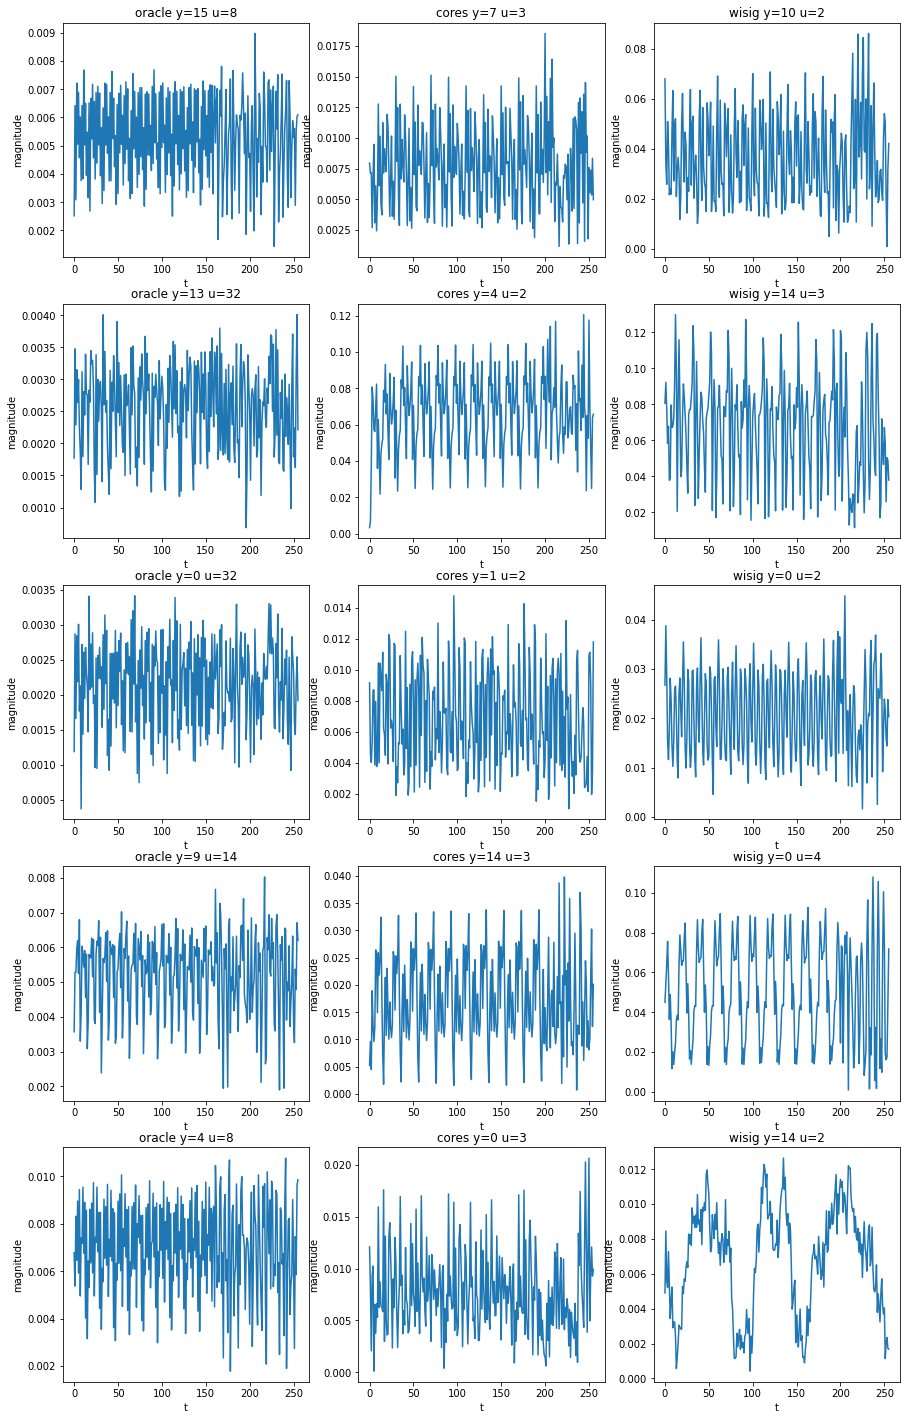

In [11]:
plt.figure(figsize=(15,N*5))

for i, ex in enumerate(oracle_orig):
    ax = plt.subplot(N,3,i*3+1)
    do_time_plot("oracle", ex, ax)
for i, ex in enumerate(cores_orig):
    ax = plt.subplot(N,3,i*3+2)
    do_time_plot("cores", ex, ax)
for i, ex in enumerate(wisig_orig):
    ax = plt.subplot(N,3,i*3+3)
    do_time_plot("wisig", ex, ax)

# Normalization

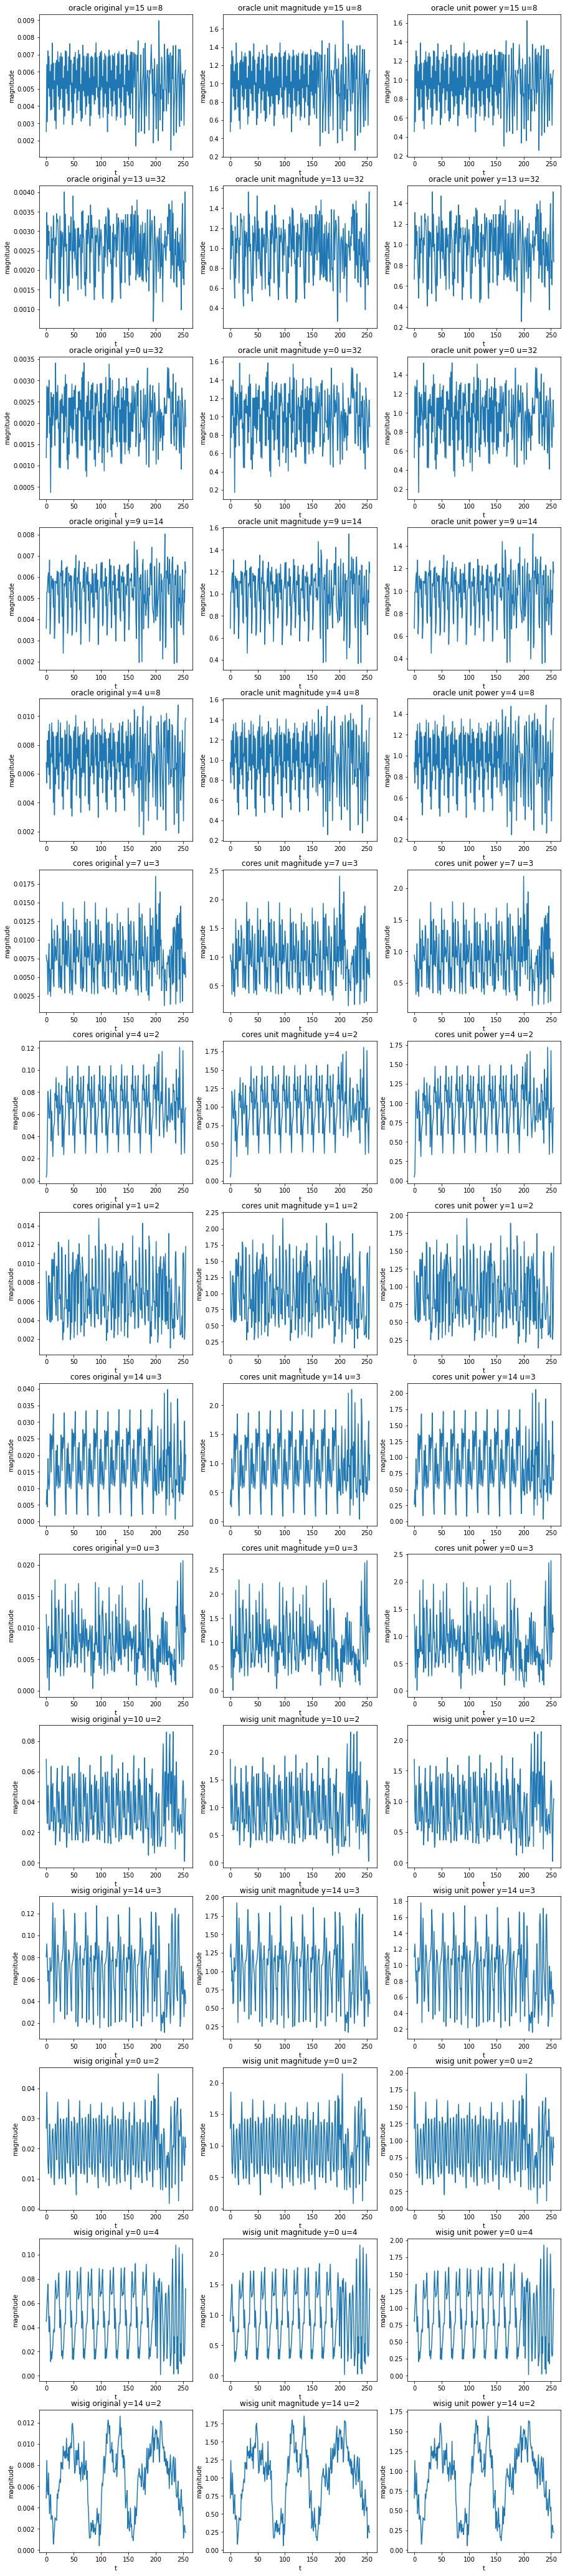

In [12]:
oracle = zip([("oracle original", x) for x in oracle_orig], [("oracle unit magnitude", x) for x in oracle_unit_mag], [("oracle unit power", x) for x in oracle_unit_power])
cores = zip([("cores original", x) for x in cores_orig], [("cores unit magnitude", x) for x in cores_unit_mag], [("cores unit power", x) for x in cores_unit_power])
wisig = zip([("wisig original", x) for x in wisig_orig], [("wisig unit magnitude", x) for x in wisig_unit_mag], [("wisig unit power", x) for x in wisig_unit_power])

plt.figure(figsize=(15,N*5*3))
for i, (o, m, p) in enumerate(list(oracle) + list(cores) + list(wisig)):
    ax = plt.subplot(N*3,3,i*3+1)
    do_time_plot(o[0], o[1], ax)
    
    ax = plt.subplot(N*3,3,i*3+2)
    do_time_plot(m[0], m[1], ax)
    
    ax = plt.subplot(N*3,3,i*3+3)
    do_time_plot(p[0], p[1], ax)

# Upsampled ORACLE and Clip (Time Domain)
To mitigate these difference, we upsample ORACLE to 25Msps (the same as cores/wisig) and then we clip all signals to 200 samples (this is the expected length of the training sequence at 25Msps).  
The time domain IQ looks more similar, but there are still difference

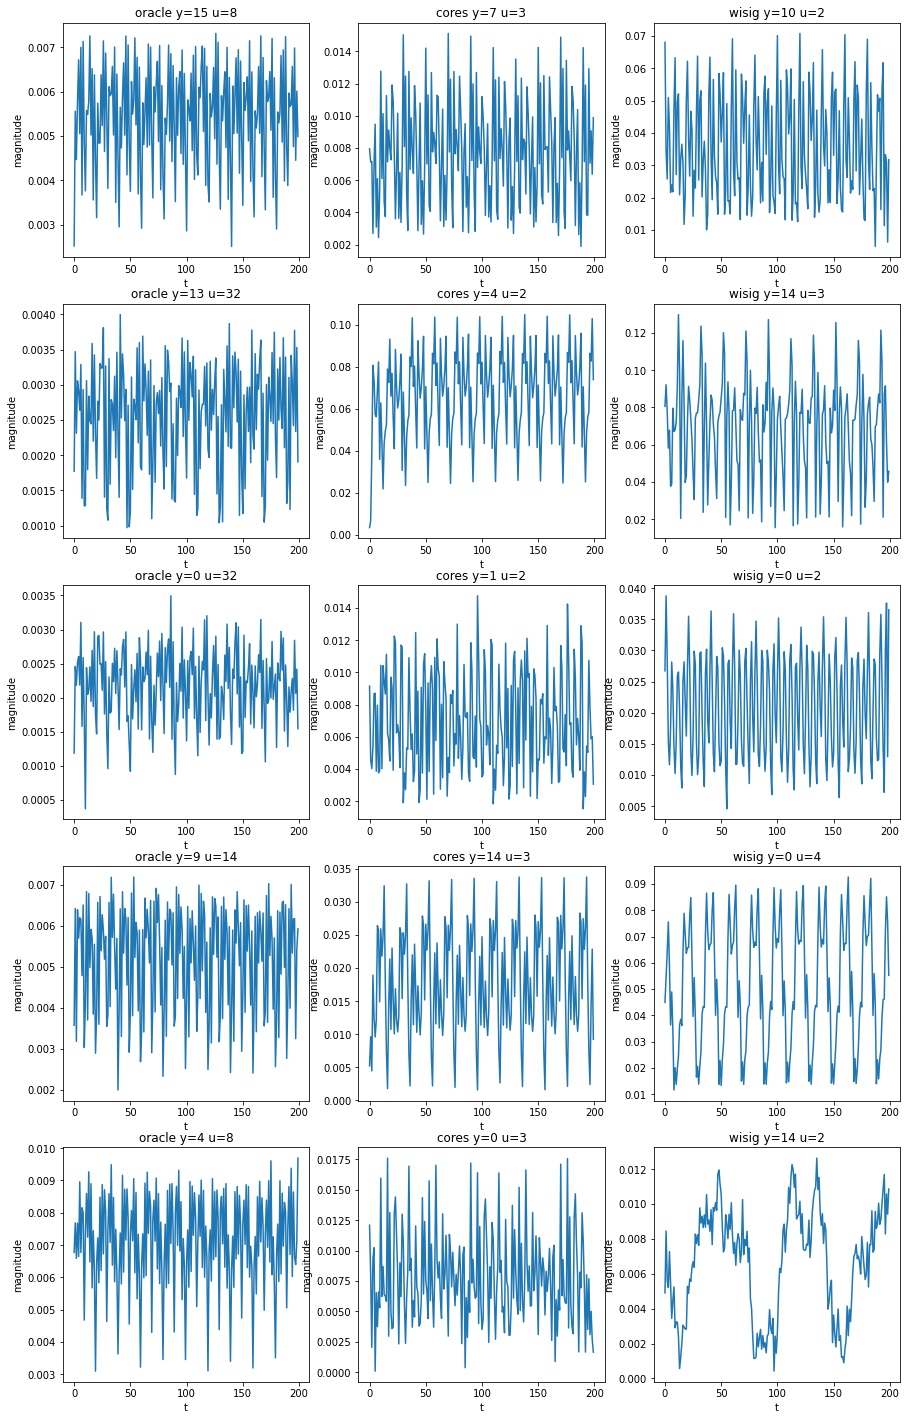

In [13]:
plt.figure(figsize=(15,N*5))

for i, ex in enumerate(oracle_resamp):
    ax = plt.subplot(N,3,i*3+1)
    do_time_plot("oracle", ex, ax)
for i, ex in enumerate(cores_resamp):
    ax = plt.subplot(N,3,i*3+2)
    do_time_plot("cores", ex, ax)
for i, ex in enumerate(wisig_resamp):
    ax = plt.subplot(N,3,i*3+3)
    do_time_plot("wisig", ex, ax)

# Upsampled ORACLE and Clip (Frequency Domain)
CORES and ORACLE look somewhat similar (though some cores samples look bizarre), wisig looks very bizarre, and even the somewhat normal spectra appear to be shifted

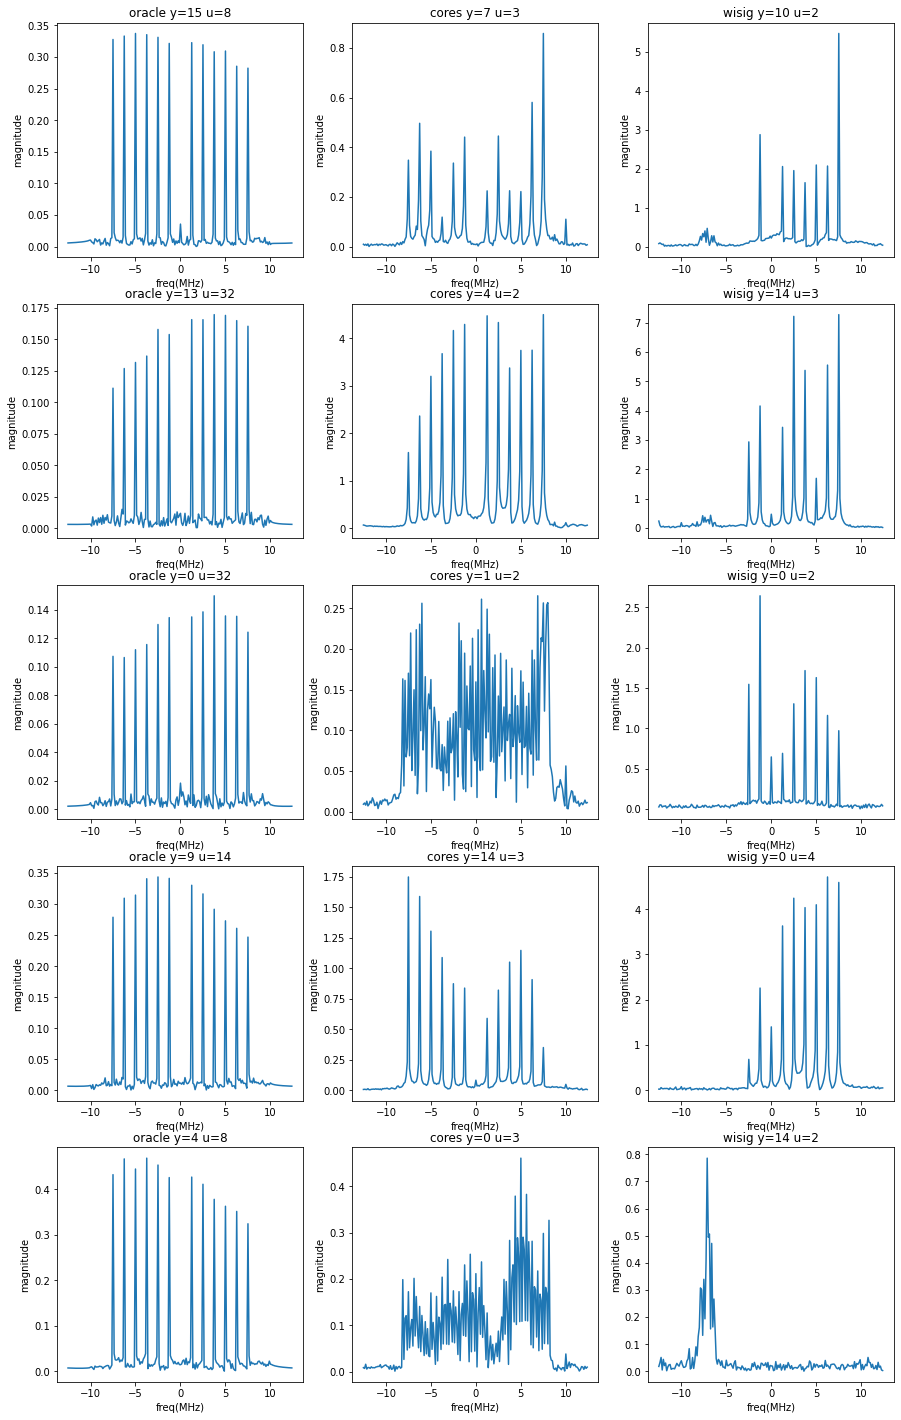

In [14]:
plt.figure(figsize=(15,N*5))

for i, ex in enumerate(oracle_resamp):
    ax = plt.subplot(N,3,i*3+1)
    do_frequency_plot("oracle", ex, ax)
for i, ex in enumerate(cores_resamp):
    ax = plt.subplot(N,3,i*3+2)
    do_frequency_plot("cores", ex, ax)
for i, ex in enumerate(wisig_resamp):
    ax = plt.subplot(N,3,i*3+3)
    do_frequency_plot("wisig", ex, ax)

# Upsampled ORACLE, Filtered WISIG and CORES (Time Domain)
ORACLE was originally sampled at 20Msps, meaning that the upsample to 25Msps does not contain frequencies above +/- 10MHz.  
To deal with this we apply a filter to CORES and WISIG for +/- 10MHz. The time domain appears unaffected

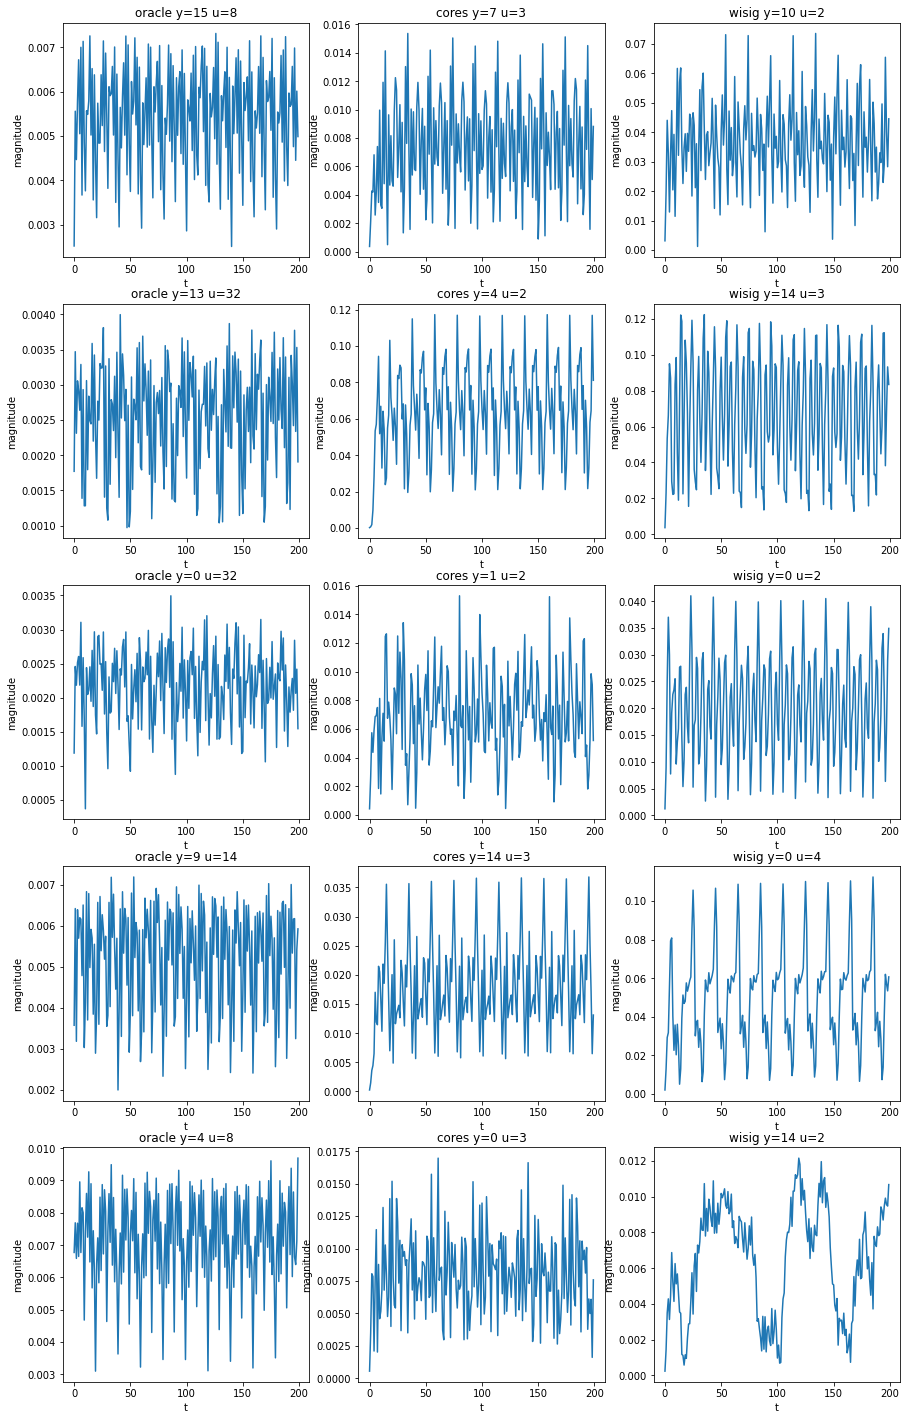

In [15]:
plt.figure(figsize=(15,N*5))

for i, ex in enumerate(oracle_filter):
    ax = plt.subplot(N,3,i*3+1)
    do_time_plot("oracle", ex, ax)
for i, ex in enumerate(cores_filter):
    ax = plt.subplot(N,3,i*3+2)
    do_time_plot("cores", ex, ax)
for i, ex in enumerate(wisig_filter):
    ax = plt.subplot(N,3,i*3+3)
    do_time_plot("wisig", ex, ax)

# Upsampled ORACLE, Filtered WISIG and CORES (Frequency Domain)
We can see CORES and WISIG are now quiet past +/- 10MHz. Besides the intended filtering, their spectra do not appear to be changed.

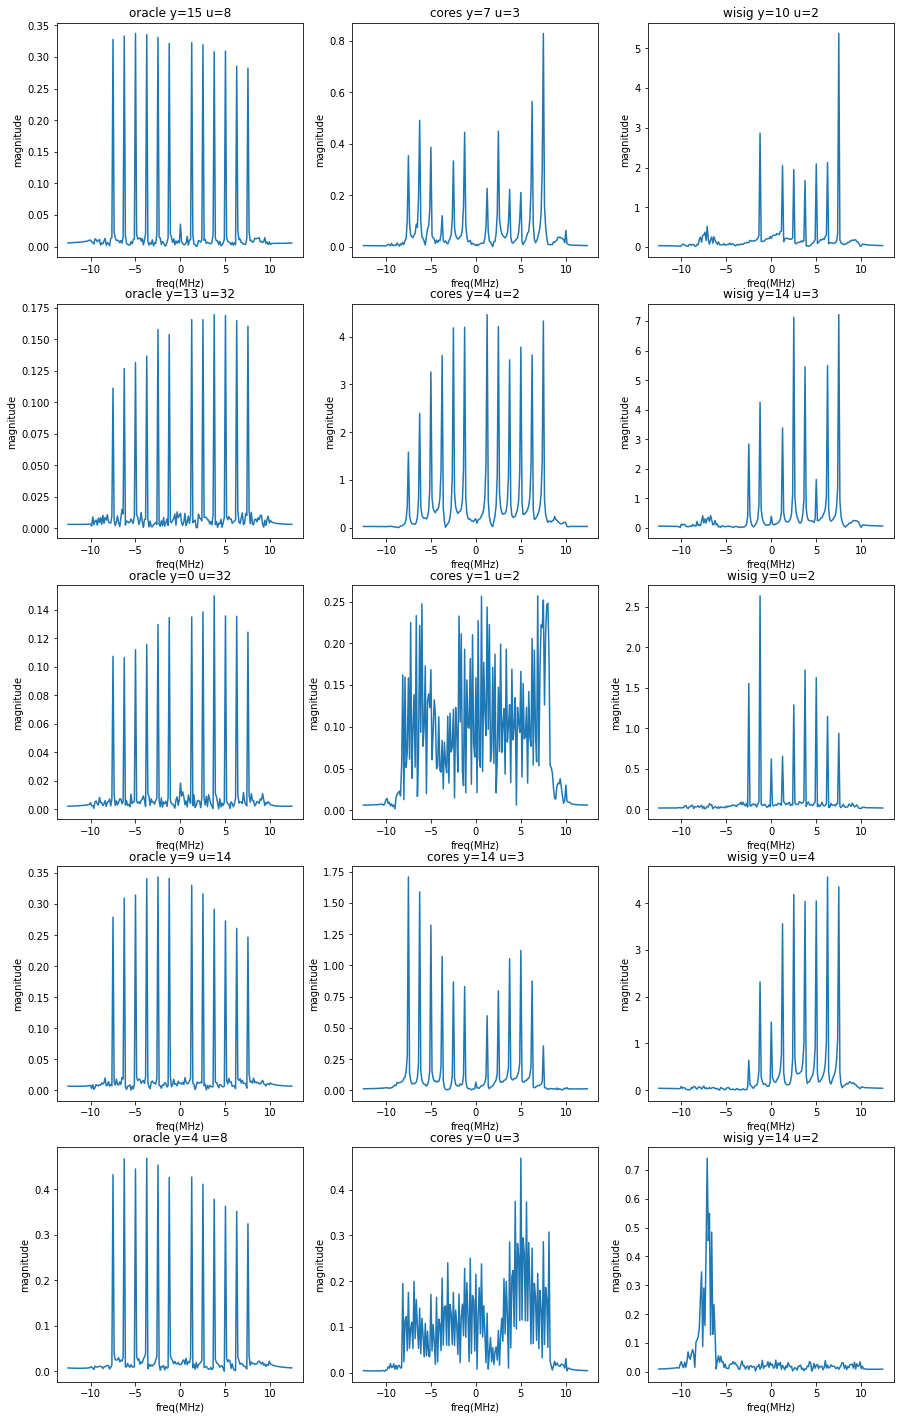

In [16]:
plt.figure(figsize=(15,N*5))

for i, ex in enumerate(oracle_filter):
    ax = plt.subplot(N,3,i*3+1)
    do_frequency_plot("oracle", ex, ax)
for i, ex in enumerate(cores_filter):
    ax = plt.subplot(N,3,i*3+2)
    do_frequency_plot("cores", ex, ax)
for i, ex in enumerate(wisig_filter):
    ax = plt.subplot(N,3,i*3+3)
    do_frequency_plot("wisig", ex, ax)

# Jittered ORACLE and CORES

## Jitter(1)

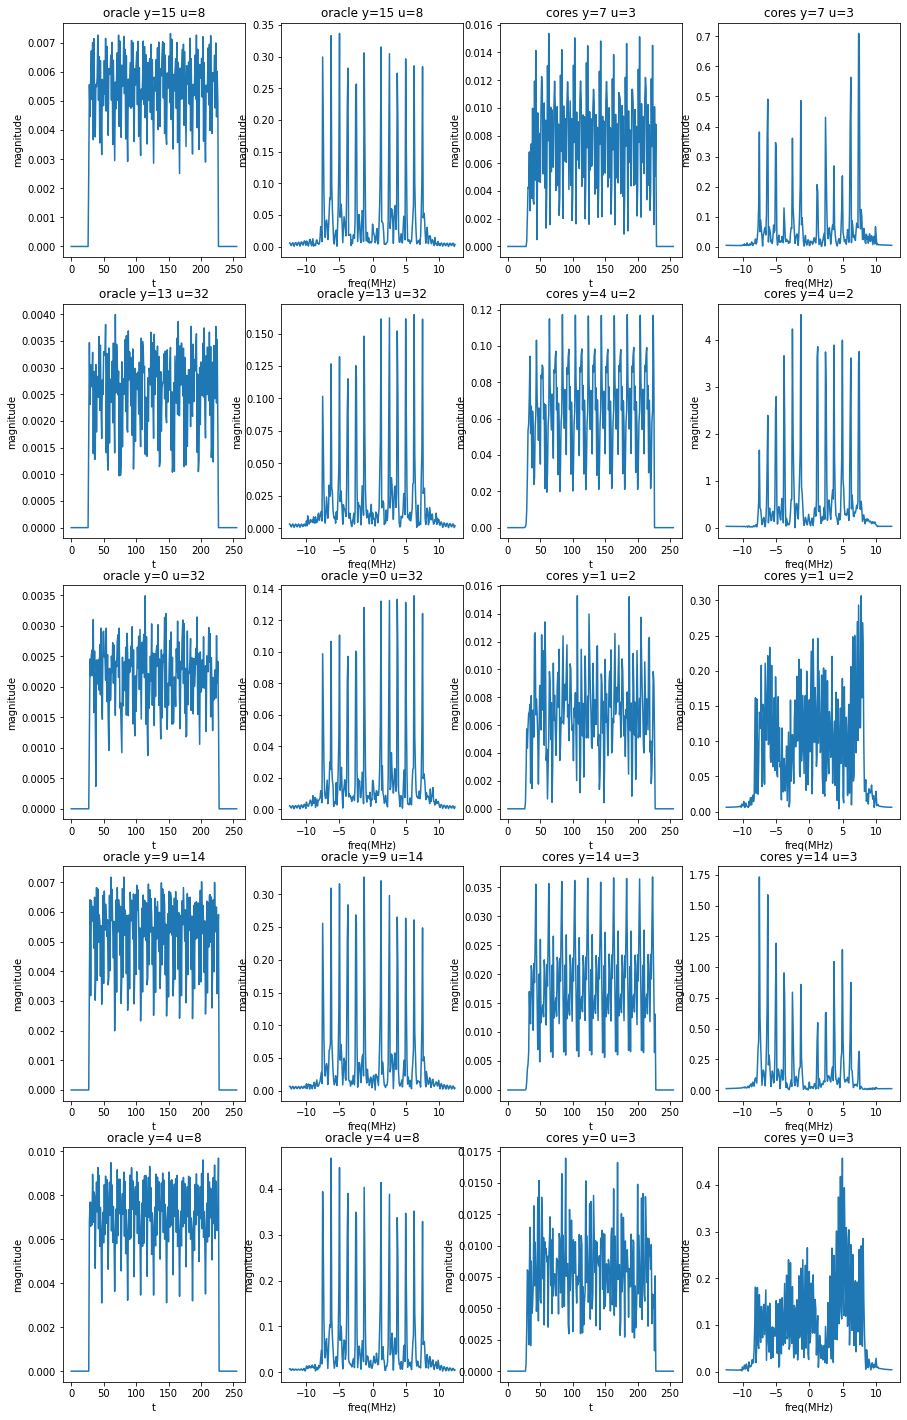

In [17]:
oracle_jitter_1 = get_examples(
    pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
    labels=ALL_SERIAL_NUMBERS,
    domains=ALL_DISTANCES_FEET_NARROWED,
    x_transforms = ["jitter_256_1", "take_200", "resample_20Msps_to_25Msps"]
)

cores_jitter_1 = get_examples(
    pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
    labels=ALL_NODES,
    domains=ALL_DAYS,
    x_transforms = ["jitter_256_1", "lowpass_+/-10MHz", "take_200"]
)

plt.figure(figsize=(15,N*5))

for i, ex in enumerate(oracle_jitter_1):
    ax = plt.subplot(N,4,i*4+1)
    do_time_plot("oracle", ex, ax)
for i, ex in enumerate(oracle_jitter_1):
    ax = plt.subplot(N,4,i*4+2)
    do_frequency_plot("oracle", ex, ax)
for i, ex in enumerate(cores_jitter_1):
    ax = plt.subplot(N,4,i*4+3)
    do_time_plot("cores", ex, ax)
for i, ex in enumerate(cores_jitter_1):
    ax = plt.subplot(N,4,i*4+4)
    do_frequency_plot("cores", ex, ax)

## Jitter(5)

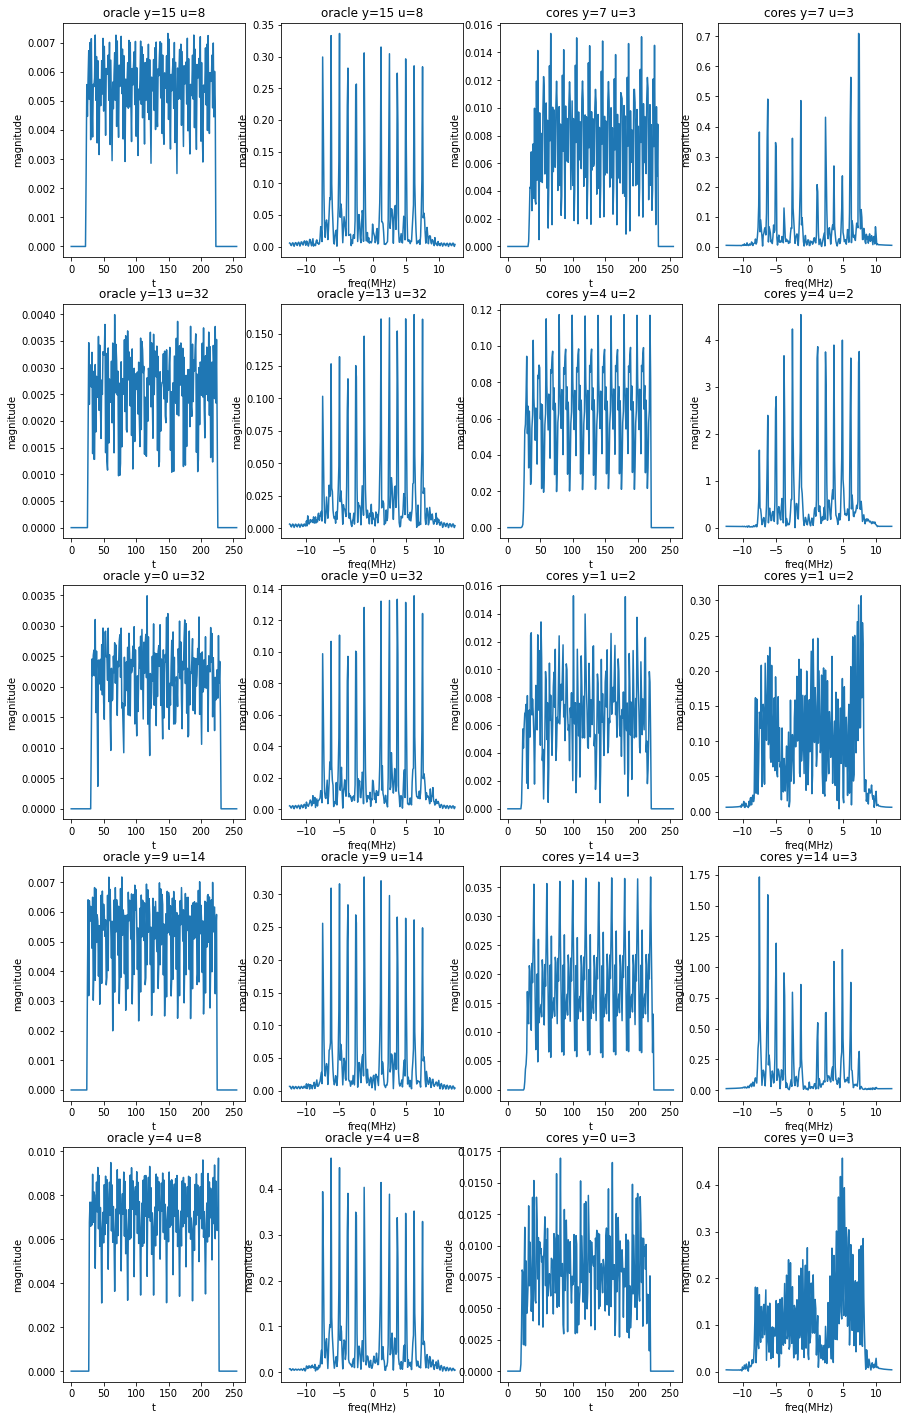

In [18]:
oracle_jitter_1 = get_examples(
    pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
    labels=ALL_SERIAL_NUMBERS,
    domains=ALL_DISTANCES_FEET_NARROWED,
    x_transforms = ["jitter_256_5", "take_200", "resample_20Msps_to_25Msps"]
)

cores_jitter_1 = get_examples(
    pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
    labels=ALL_NODES,
    domains=ALL_DAYS,
    x_transforms = ["jitter_256_5", "lowpass_+/-10MHz", "take_200"]
)

plt.figure(figsize=(15,N*5))

for i, ex in enumerate(oracle_jitter_1):
    ax = plt.subplot(N,4,i*4+1)
    do_time_plot("oracle", ex, ax)
for i, ex in enumerate(oracle_jitter_1):
    ax = plt.subplot(N,4,i*4+2)
    do_frequency_plot("oracle", ex, ax)
for i, ex in enumerate(cores_jitter_1):
    ax = plt.subplot(N,4,i*4+3)
    do_time_plot("cores", ex, ax)
for i, ex in enumerate(cores_jitter_1):
    ax = plt.subplot(N,4,i*4+4)
    do_frequency_plot("cores", ex, ax)

## Jitter(10)

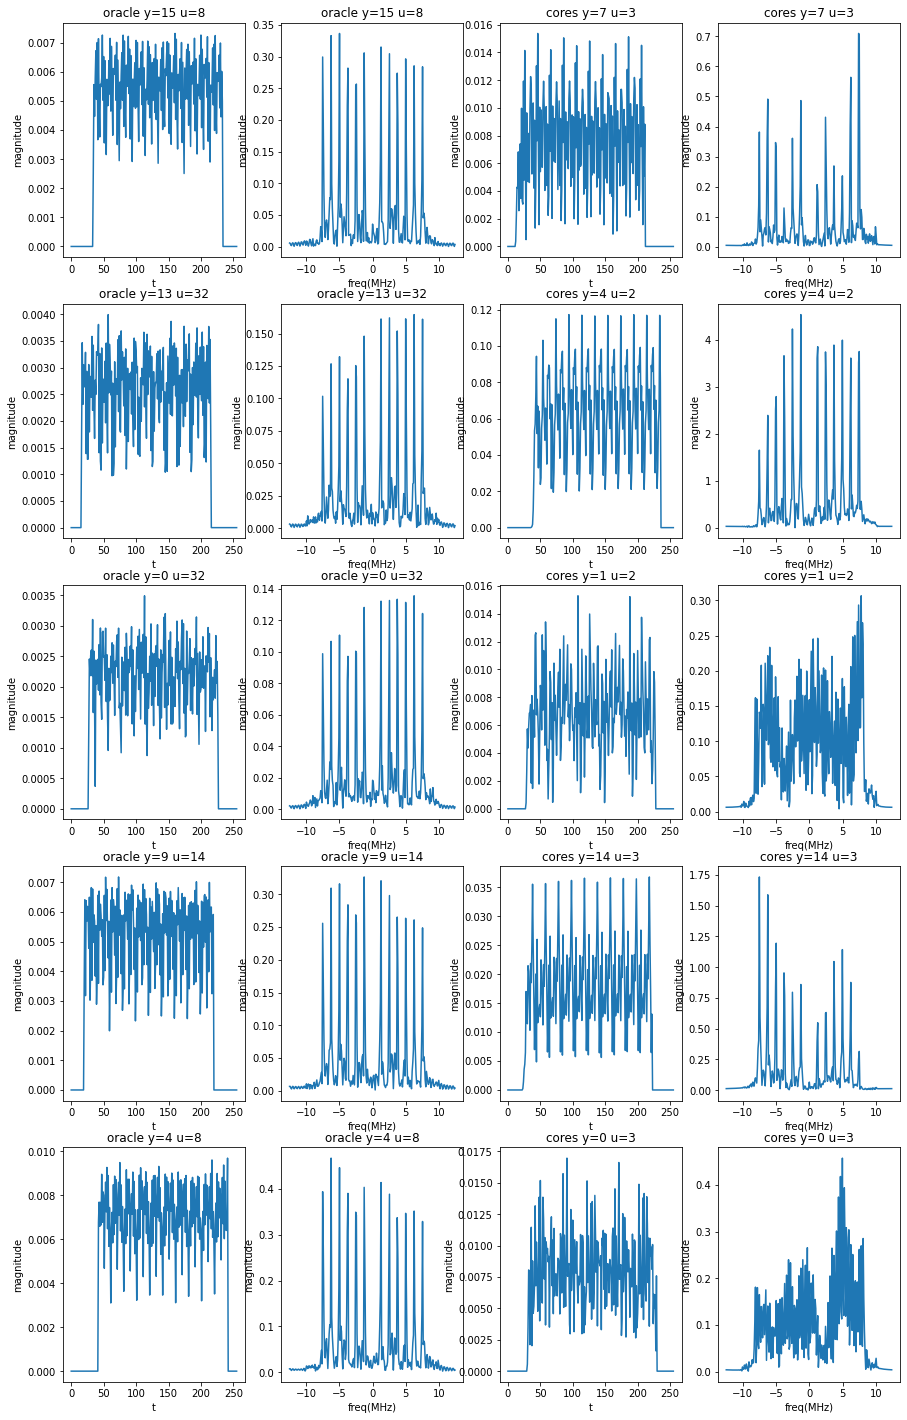

In [19]:
oracle_jitter_1 = get_examples(
    pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
    labels=ALL_SERIAL_NUMBERS,
    domains=ALL_DISTANCES_FEET_NARROWED,
    x_transforms = ["jitter_256_10", "take_200", "resample_20Msps_to_25Msps"]
)

cores_jitter_1 = get_examples(
    pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
    labels=ALL_NODES,
    domains=ALL_DAYS,
    x_transforms = ["jitter_256_10", "lowpass_+/-10MHz", "take_200"]
)

plt.figure(figsize=(15,N*5))

for i, ex in enumerate(oracle_jitter_1):
    ax = plt.subplot(N,4,i*4+1)
    do_time_plot("oracle", ex, ax)
for i, ex in enumerate(oracle_jitter_1):
    ax = plt.subplot(N,4,i*4+2)
    do_frequency_plot("oracle", ex, ax)
for i, ex in enumerate(cores_jitter_1):
    ax = plt.subplot(N,4,i*4+3)
    do_time_plot("cores", ex, ax)
for i, ex in enumerate(cores_jitter_1):
    ax = plt.subplot(N,4,i*4+4)
    do_frequency_plot("cores", ex, ax)